<a href="https://colab.research.google.com/github/swarthyPig/Raspberry-Pi_DHT22_Weather_Station_with_AI/blob/master/machine%20learning/Keras_MRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


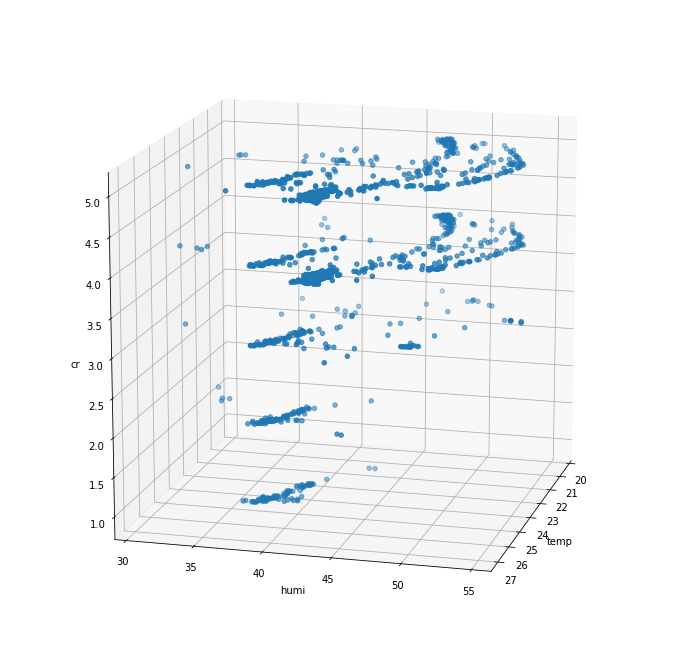

In [0]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop

import numpy as np
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

data = read_csv('iot_data.csv', sep=',')

data = np.array(data, dtype=np.float32)

xs = np.array(data[:,1], dtype=np.float32)
ys = np.array(data[:,2], dtype=np.float32)
zs = np.array(data[:,-1], dtype=np.float32)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('temp')
ax.set_ylabel('humi')
ax.set_zlabel('cr')
ax.view_init(15, 15)

plt.show()

In [0]:
# data split
from sklearn.model_selection import train_test_split

x_data = data[0:-1, 1:-1] # temp, humi

y_data = data[0:-1, [-1]] # cr

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                    test_size=0.2, random_state=0)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1192, 2)
(1192, 1)
(299, 2)
(299, 1)


In [0]:
model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [0]:
hist = model.fit(x_train, y_train, epochs = 100, batch_size=10, verbose=1)

Epoch 1/100
1192/1192 [==============================] - 1s 434us/step - loss: 2411.8372 - acc: 0.0000e+00
Epoch 2/100
1192/1192 [==============================] - 0s 98us/step - loss: 1706.9047 - acc: 0.0000e+00
Epoch 3/100
1192/1192 [==============================] - 0s 96us/step - loss: 1172.5814 - acc: 0.0000e+00
Epoch 4/100
1192/1192 [==============================] - 0s 96us/step - loss: 777.9529 - acc: 0.0000e+00
Epoch 5/100
1192/1192 [==============================] - 0s 98us/step - loss: 497.1686 - acc: 0.0000e+00
Epoch 6/100
1192/1192 [==============================] - 0s 92us/step - loss: 304.6179 - acc: 0.0000e+00
Epoch 7/100
1192/1192 [==============================] - 0s 90us/step - loss: 178.4081 - acc: 0.0000e+00
Epoch 8/100
1192/1192 [==============================] - 0s 101us/step - loss: 99.6418 - acc: 0.0000e+00
Epoch 9/100
1192/1192 [==============================] - 0s 94us/step - loss: 52.9924 - acc: 0.0000e+00
Epoch 10/100
1192/1192 [============================

In [0]:
print('## training loss and acc ##')
# print(hist.history['loss'])
# print(hist.history['acc'])


## training loss and acc ##


In [0]:
# list all data in history
print(hist.history.keys())

dict_keys(['loss', 'acc'])


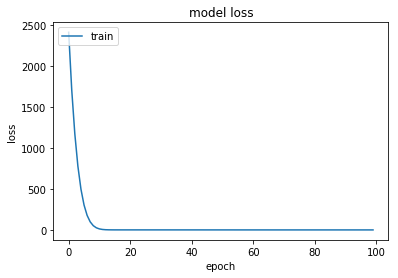

In [0]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# model에 임의의 값을 넣어 test
#model.predict(x_train)
model.predict(np.array([23,43]).reshape(1,2))

array([[3.9350345]], dtype=float32)

In [0]:
# 모델평가
test_loss, test_acc = model.evaluate(x_test, y_test)
print('정확도 :', test_acc)

299/299 [==============================] - 0s 588us/step
정확도 : 0.38795986661942905


In [0]:
# get weight, bias value
W_, b_ = model.get_weights()
print(W_)
print('weigth : ', W_[0],W_[1]) 
print('bias : ', b_)

[[0.0301453 ]
 [0.09299916]]
weigth :  [0.0301453] [0.09299916]
bias :  [-0.757271]


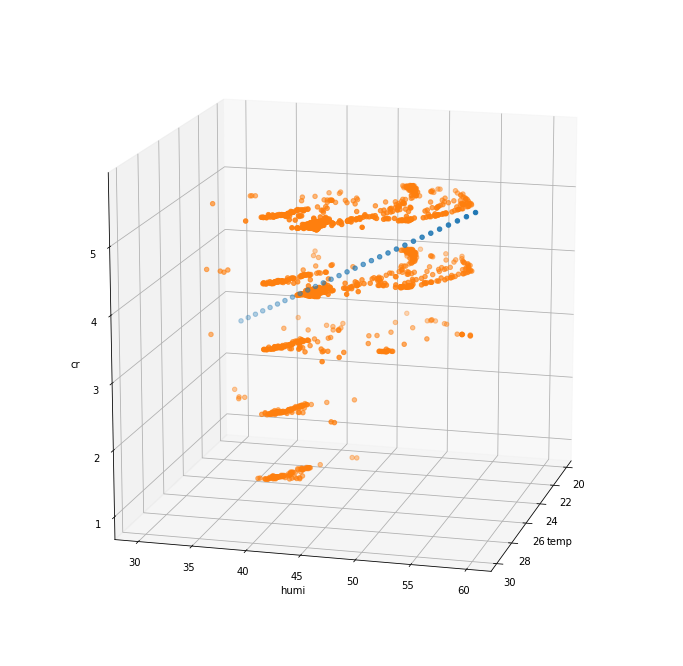

In [0]:
x = np.linspace(20, 30, 30).reshape(30,1) # Temp range(20~30, 간격:30)
y = np.linspace(30, 60, 30).reshape(30,1) # Humi range(30~60, 간격:30)

X = np.concatenate((x,y), axis=1)
Z = np.matmul(X, W_) + b_

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, Z)
ax.scatter(xs, ys, zs)
ax.set_xlabel('temp')
ax.set_ylabel('humi')
ax.set_zlabel('cr')
ax.view_init(15, 15)

plt.show()

### New keras model

In [0]:
# Keras
# from keras.models import Sequential
# from keras.layers import Dense
import keras
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

In [0]:
x_data.shape,x_train.shape,y_train.shape,x_test.shape,y_test.shape

((1491, 2), (1192, 2), (1192, 1), (299, 2), (299, 1))

### Simple model - one layer

In [0]:
# create simple model with light model capacity 
model_s = Sequential()  # simple model

#get number of columns in training data
n_cols = x_train.shape[1]
print(n_cols)
#add layers to model
model_s.add(Dense(10, activation='relu', input_shape=(n_cols,)))
# model_s.add(Dense(10, activation='relu'))
model_s.add(Dense(1, activation='relu'))

2


In [0]:
model_s.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [0]:
# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for 3, 5 or 10 consecutive epochs,
# training stops early
# and save the best model
callbacks_list = [
#    keras.callbacks.ModelCheckpoint(
#        filepath='best_model_s.{epoch:02d}-{val_loss:.2f}.h5',
#        monitor='val_loss', save_best_only=True),
#    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  # monitor='acc', patience=3
]

In [0]:
# compile model using mse as a measure of model performance
model_s.compile(optimizer='adam', loss='mean_squared_error')

# set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=3)

In [0]:
# train model with all data
model_s.fit(x_train, y_train, validation_split=0.25, 
            epochs=50, callbacks=callbacks_list)

print('\nAccuracy: {:.4f}'.format(model_s.evaluate(x_test, y_test)))

Train on 894 samples, validate on 298 samples
Epoch 1/50
894/894 [==============================] - 0s 199us/step - loss: 8.9557 - val_loss: 3.6549
Epoch 2/50
894/894 [==============================] - 0s 34us/step - loss: 2.8967 - val_loss: 2.4864
Epoch 3/50
894/894 [==============================] - 0s 34us/step - loss: 2.4629 - val_loss: 2.3854
Epoch 4/50
894/894 [==============================] - 0s 31us/step - loss: 2.3549 - val_loss: 2.2736
Epoch 5/50
894/894 [==============================] - 0s 33us/step - loss: 2.2399 - val_loss: 2.1652
Epoch 6/50
894/894 [==============================] - 0s 33us/step - loss: 2.0920 - val_loss: 2.0335
Epoch 7/50
894/894 [==============================] - 0s 34us/step - loss: 1.9763 - val_loss: 1.9312
Epoch 8/50
894/894 [==============================] - 0s 33us/step - loss: 1.8593 - val_loss: 1.9004
Epoch 9/50
894/894 [==============================] - 0s 35us/step - loss: 1.7762 - val_loss: 1.7626
Epoch 10/50
894/894 [=======================

### Increase model capacity

In [0]:
# training a new model on the same data to show the effect of increasing model capacity
model_b = Sequential()

#get number of columns in training data
n_cols = x_train.shape[1]

#add model layers
model_b.add(Dense(200, activation='relu', input_shape=(n_cols,)))
model_b.add(Dense(100, activation='relu'))
model_b.add(Dense(20, activation='relu'))
model_b.add(Dense(1, activation='relu'))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 22,741
Trainable params: 22,741
Non-trainable params: 0
_________________________________________________________________


In [0]:
# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for 3, 5 or 10 consecutive epochs,
# training stops early
# and save the best model
callbacks_list = [
#    keras.callbacks.ModelCheckpoint(
#        filepath='best_model_b.{epoch:02d}-{val_loss:.2f}.h5',
#        monitor='val_loss', save_best_only=True),
#    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  # monitor='acc', patience=3
]

In [0]:
# compile model using mse as a measure of model performance
model_b.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['accuracy'])   # loss='sparse_categorical_crossentropy', 'mean_squared_error'

In [0]:
hist = model_b.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=100, 
                   batch_size=50, callbacks=callbacks_list)

print('\nAccuracy: {:.4f}'.format(model_b.evaluate(x_test, y_test)[1]))

Instructions for updating:
Use tf.cast instead.
Train on 1192 samples, validate on 299 samples
Epoch 1/100
1192/1192 [==============================] - 0s 233us/step - loss: 2.1563 - acc: 0.2970 - val_loss: 1.3653 - val_acc: 0.4147
Epoch 2/100
1192/1192 [==============================] - 0s 45us/step - loss: 1.1239 - acc: 0.3733 - val_loss: 1.1164 - val_acc: 0.3746
Epoch 3/100
1192/1192 [==============================] - 0s 42us/step - loss: 1.1230 - acc: 0.3716 - val_loss: 1.1098 - val_acc: 0.3712
Epoch 4/100
1192/1192 [==============================] - 0s 43us/step - loss: 1.1121 - acc: 0.3750 - val_loss: 1.1009 - val_acc: 0.3813
Epoch 5/100
1192/1192 [==============================] - 0s 43us/step - loss: 1.1235 - acc: 0.3758 - val_loss: 1.1182 - val_acc: 0.3980
Epoch 6/100
1192/1192 [==============================] - 0s 43us/step - loss: 1.1343 - acc: 0.3767 - val_loss: 1.2562 - val_acc: 0.4181
Epoch 7/100
1192/1192 [==============================] - 0s 43us/step - loss: 1.1347 - a

> val_loss가 현저히 줄어듬 -> 모델 

### Performance of model_s and model_b

> Split dataframe into the train and test set

In [0]:
# get predictions
y_pred = model_s.predict(x_test)
y_pred[:5].ravel()

array([4.6138444, 4.0915256, 3.5670435, 3.3518038, 3.7269738],
      dtype=float32)

In [0]:
y_pred.ravel()

array([4.6138444, 4.0915256, 3.5670435, 3.3518038, 3.7269738, 3.4224384,
       3.8155696, 3.403975 , 4.134934 , 3.7124648, 4.0841756, 4.2720084,
       3.7269738, 3.4426253, 3.6981363, 3.446641 , 4.350706 , 3.8732433,
       3.3934202, 3.3999643, 3.34563  , 4.6086516, 3.7609284, 3.7955055,
       4.356204 , 3.4980729, 3.7309864, 4.1673727, 3.8283532, 3.3379745,
       3.6978316, 4.126906 , 3.766803 , 3.8195872, 3.4918337, 4.13577  ,
       3.428059 , 3.5805666, 4.091184 , 4.5720544, 4.518564 , 3.8240378,
       3.485594 , 3.4087312, 3.6463003, 3.804644 , 3.7528408, 4.1474094,
       4.356204 , 3.4546673, 3.7834647, 4.574584 , 4.0045033, 4.3688545,
       4.6258802, 4.0571938, 3.489306 , 4.5939116, 3.4772632, 3.6948655,
       3.7721672, 3.7889605, 3.733515 , 4.0765185, 4.1411324, 3.3604472,
       3.801743 , 4.1123333, 4.2939467, 3.734696 , 3.4976373, 3.770379 ,
       4.2149925, 4.4528303, 3.4513972, 3.5676522, 3.717899 , 3.3620555,
       3.932871 , 3.733515 , 4.1411734, 4.3602147, 

> model_s is NOT good!

In [0]:
# get predictions
y_pred = model_b.predict(x_test)
y_pred[:5]

array([[4.7794385],
       [4.255259 ],
       [3.8329272],
       [3.3048484],
       [4.0516467]], dtype=float32)

In [0]:
print(y_pred.ravel())
print(y_test.ravel())

[4.7794385 4.255259  3.8329272 3.3048484 4.0516467 3.4628708 4.29867
 3.419726  4.286639  4.002044  4.2263713 4.416827  4.0516467 3.541385
 3.99968   3.5507903 4.6797566 4.3592815 3.3678994 3.4104245 3.2587779
 4.7397423 4.187914  4.271112  4.6944675 3.6869147 4.061051  4.4526925
 4.314206  3.2357836 3.9209487 4.2799025 4.066961  4.303175  3.719106
 4.484724  3.4760365 3.8334095 4.4165134 4.8150425 4.679284  4.258038
 3.7512982 3.4155319 4.0045624 4.2746434 4.154855  4.327401  4.6944675
 3.5695992 4.2487373 4.8070693 4.42208   4.6546    4.7895436 4.2113
 3.6819706 4.8182397 3.6537569 3.9764104 4.2133255 4.236795  4.0962453
 4.2224703 4.4432907 3.2840152 4.251199  4.277771  4.546302  3.9917235
 3.779511  4.165385  4.5710006 4.75032   3.546329  3.9818716 3.9679723
 3.2874599 4.3069572 4.0962453 4.3070197 4.6978354 3.383132  4.165385
 4.1903033 3.722868  4.114495  4.046703  4.2744026 3.8082085 4.764729
 4.106774  4.004374  3.8712733 4.4096675 4.0143833 4.271112  3.2443967
 4.0516467 3.995

# Check model_b

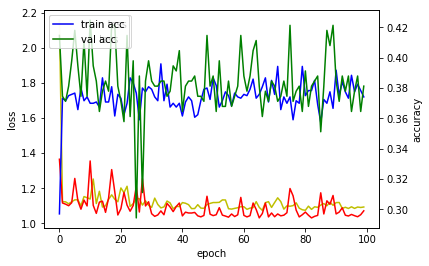

In [0]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

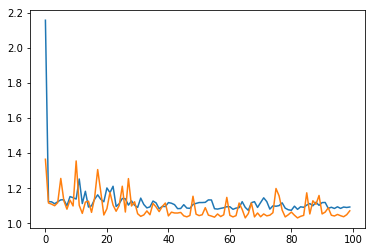

In [0]:
# Plot performance
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

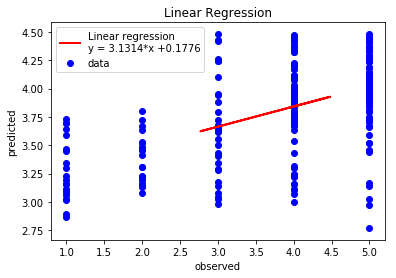

In [0]:
# print the linear regression and display datapoints
from sklearn.linear_model import LinearRegression  
regressor = LinearRegression()  
true_y=y_test #[:,np.newaxis] # np.argmax(y_test, axis=1)  # decode one-hot encoding
regressor.fit(true_y, y_pred)  
y_fit = regressor.predict(y_pred) 

reg_intercept = round(regressor.intercept_[0],4)
reg_coef = round(regressor.coef_.flatten()[0],4)
reg_label = "y = " + str(reg_intercept) + "*x +" + str(reg_coef)

plt.scatter(true_y, y_pred, color='blue', label= 'data')
plt.plot(y_pred, y_fit, color='red', linewidth=2, label = 'Linear regression\n'+reg_label) 
plt.title('Linear Regression')
plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

In [0]:
# 모델평가
test_loss, test_acc = model_b.evaluate(x_test, y_test)
print('정확도 :', test_acc)

299/299 [==============================] - 0s 29us/step
정확도 : 0.3812709034087267


In [0]:
# get weight, bias value
print(model_b.get_weights())

[array([[-9.80750769e-02, -5.57131991e-02, -2.57375892e-02,
         1.25427783e-01,  7.63188303e-03,  9.51072723e-02,
         7.75637478e-02,  1.02470309e-01, -1.03912041e-01,
        -1.48292184e-01,  2.62849554e-02, -1.49149269e-01,
        -5.23235928e-03, -5.67601137e-02,  3.25857066e-02,
        -1.02368761e-02, -7.23955035e-03, -9.42555591e-02,
        -1.21721797e-01, -1.67995021e-01, -1.93567332e-02,
        -3.74532938e-02,  1.20072745e-01, -8.27990249e-02,
         1.29954323e-01, -4.56421077e-02,  1.64833397e-01,
        -1.72762945e-01, -1.02738971e-02, -9.47807208e-02,
         3.22677419e-02, -1.38163164e-01,  4.16921377e-02,
         1.31469026e-01, -1.13573708e-01, -6.07150979e-02,
        -3.63230705e-02, -1.67379647e-01, -6.54735193e-02,
         9.20115411e-03, -6.18261732e-02, -2.80883107e-02,
         6.84530139e-02,  7.88225383e-02, -3.29855792e-02,
         2.00851932e-02, -1.32857770e-01, -9.76276398e-02,
        -1.11227073e-01,  1.72245428e-02, -6.24269173e-

***

In [0]:
# import keras

In [0]:
# #-----------------------------------------------------------------_______------------
# # Define custom loss functions for regression in Keras 
# #
# # The functions below are Keras backend tensor functions 
# # and can be used for Keras loss functions, Keras metrics and Keras learning curves. 
# #------------------------------------------------------------------_______-----------
# # https://github.com/keras-team/keras/issues/7947

# # root mean squared error (rmse) for regression (only for Keras tensors)
# def rmse(y_true, y_pred):
#     from keras import backend
#     return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# # mean squared error (mse) for regression  (only for Keras tensors)
# def mse(y_true, y_pred):
#     from keras import backend
#     return backend.mean(backend.square(y_pred - y_true), axis=-1)

# # coefficient of determination (R^2) for regression  (only for Keras tensors)
# def r_square(y_true, y_pred):
#     from keras import backend as K
#     SS_res =  K.sum(K.square(y_true - y_pred)) 
#     SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
#     return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# def r_square_loss(y_true, y_pred):
#     from keras import backend as K
#     SS_res =  K.sum(K.square(y_true - y_pred)) 
#     SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
#     return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))
